In [319]:
#Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

import seaborn as sns
import matplotlib.patches as mpatches


from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics


In [320]:
#To remove warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

In [321]:
#seaborn configuration
sns.set(rc={'figure.figsize':(10,5)}) 
sns.set_style('white')
sns.set_palette ("Set1")
#sns.set(rc={'figure.figsize':(11.7,8.27)})



## Load data

In [322]:
#file = "data/old/combined_dataframe.csv"
#df = pd.read_csv(file, sep = '\t')  

In [323]:
df_2019 = pd.read_csv("data/2019.csv", sep = '\t')  
df_2020 = pd.read_csv("data/2020.csv", sep = '\t')  
df_2021 = pd.read_csv("data/2021.csv", sep = '\t')  
df_2022 = pd.read_csv("data/2022.csv", sep = '\t') 


In [324]:
df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [325]:
df.to_csv('data/combined_dataframe.csv', index=False, header=True, sep ='\t' )

### Number of races 

In [326]:
print("Number rows dataframe: ")
print(len(df))

Number rows dataframe: 
82523


### Change/add variables

In [327]:
def change_add_var(df):
    # Change the colum HasPitLap, to check if in the next lap it made the lap, and change name to PitNextLap
    #df["PitNextLap"] = df.groupby(["Year", "RaceNumber", "Driver"])["HasPitLap"].shift(-1).fillna(0)
    #df["GoodPitNextLap"] = df.groupby(["Year", "RaceNumber", "Driver"])["GoodPitStop"].shift(-1).fillna(0)

    #time

In [ ]:
df = change_add_var(df)

### Remove variables 

In [259]:
# the data was compiled, but then was not useful 
def remonve_var(df):
    df = df.drop(['DriverNumber'], axis=1)
    df = df.drop(['DriverAhead'], axis=1)
    df = df.drop(['DriverBehind'], axis=1)
    #! TODO  check if delete TimePit
    df = df.drop(['TimePit'], axis=1)
    return df

In [260]:
#! TODO
#df = df.drop(['TimeLap'], axis=1)

In [261]:
df = remonve_var(df)

## Pit stops info 

In [262]:
df["HasPitLap"].value_counts()

0.0    79873
1.0     2630
Name: HasPitLap, dtype: int64

In [263]:
df["GoodPitStop"].value_counts()

0    81152
1     1371
Name: GoodPitStop, dtype: int64

In [264]:
df["HasPitLap"].value_counts()/df.shape[0]


0.0    0.967888
1.0    0.031870
Name: HasPitLap, dtype: float64

In [265]:
df["GoodPitStop"].value_counts()/df.shape[0]


0    0.983386
1    0.016614
Name: GoodPitStop, dtype: float64

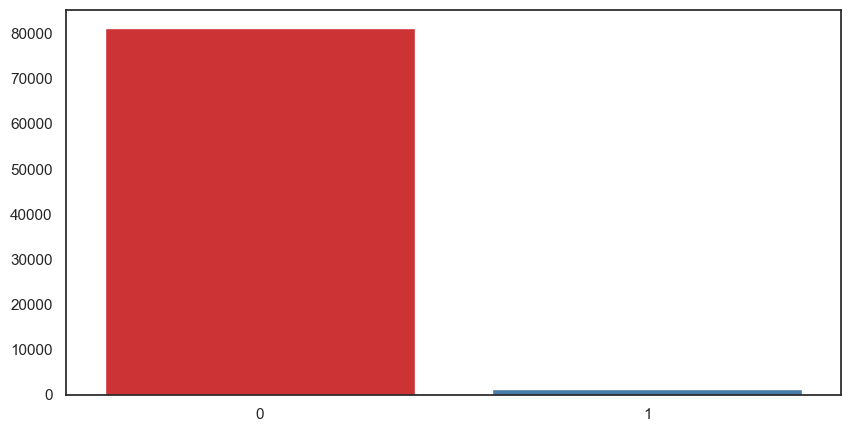

In [266]:
value_counts = df["GoodPitStop"].value_counts()

ax = sns.barplot(x=value_counts.index, y=value_counts.values)


# Data cleaning

## Rainy races
Races with rain, i.e. those in which intermediate or wet tires are used, are eliminated. 

### Plot

In [267]:
#For the spa race in 2021 we have some 'UNKNOWN' values, remove them 
df = df[df['Compound'] != 'UNKNOWN']


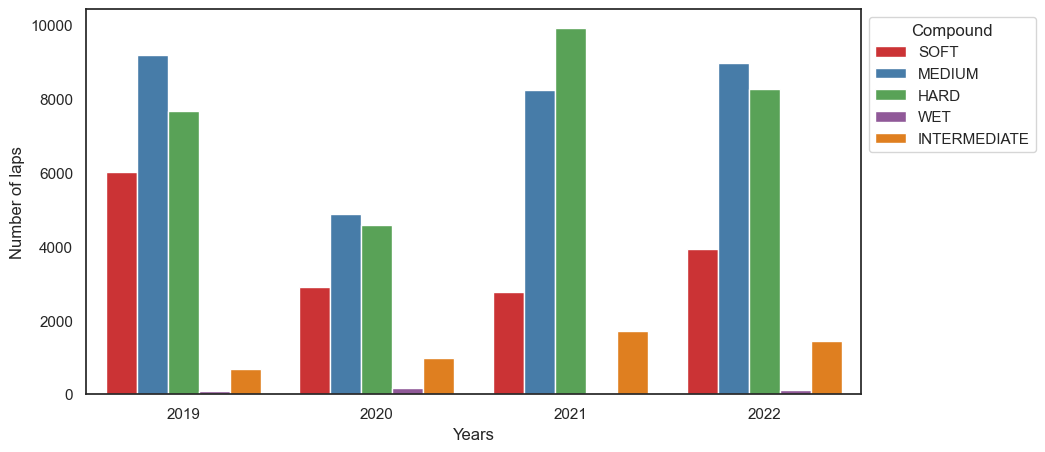

In [268]:
value_counts = df.groupby('Year')['Compound'].value_counts()
all_values = pd.MultiIndex.from_product([df['Year'].unique(), df['Compound'].unique()])
value_counts = value_counts.reindex(all_values, fill_value=0)

value_counts = value_counts.reset_index()
value_counts.columns = ['Year', 'Compound', "Value"]

# Set y-label to "number of laps"
plot = sns.barplot(x='Year', y='Value', hue='Compound', data=value_counts)
plot.set_ylabel('Number of laps')
plot.set_xlabel('Years')
plt.legend(title='Compound', bbox_to_anchor=(1, 1))


#sns.barplot(x='Year', y='Value', hue='Compound', data=value_counts,  palette={'SOFT':'r', 'MEDIUM':'y', 'HARD':'grey','INTERMEDIATE':'g', 'WET':'b'})



### Deleted 

In [269]:
def remove_rain(df):
    #Initialized in 1, because I have removed by hand spa in 2021 already gave an error 
    initial_races = 0
    rain_races= 0 
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            initial_races+=1
            val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]
            #If in that race any driver uses Intermediate or wet tyres, delete the all the sace
            if ('INTERMEDIATE' in val['Compound'].values or 'WET' in val['Compound'].values):
                rain_races +=1
                df = df.drop(val.index)

    print("Total races in the DataSet: " + str(initial_races))
    print("Number of races that have been eliminated due to rain: " + str(rain_races))

    return (df)


In [270]:
df = remove_rain(df)

Total races in the DataSet: 77
Number of races that have been eliminated due to rain: 12


## Retired or more than 4 stops 


In [271]:
def remove_retired(df):
    list_remove = pd.DataFrame()
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ('Finished' != val["ResultStatus"].iloc[0] and '+1 Lap' != val["ResultStatus"].iloc[0] and '+2 Laps' != val["ResultStatus"].iloc[0]):
                    list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': val["ResultStatus"].iloc[0]}, ignore_index=True)
                    df = df.drop(val.index)
                elif val["NumberPitStops"].iloc[-1] >4:  
                    list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': "+4 pit stops"}, ignore_index=True)
                    df = df.drop(val.index)
    
    return df, list_remove

In [272]:
df, list_remove = remove_retired(df)


### Plot

Mechanical        1
+6 Laps           1
Vibrations        1
Front wing        1
Fuel leak         1
Water pump        1
Cooling system    1
Wheel nut         1
Rear wing         1
Electrical        1
Illness           1
Radiator          1
Out of fuel       1
Transmission      1
Debris            1
Withdrew          1
Differential      1
Name: problem, dtype: int64


Text(0.5, 0, 'Reason for deleted')

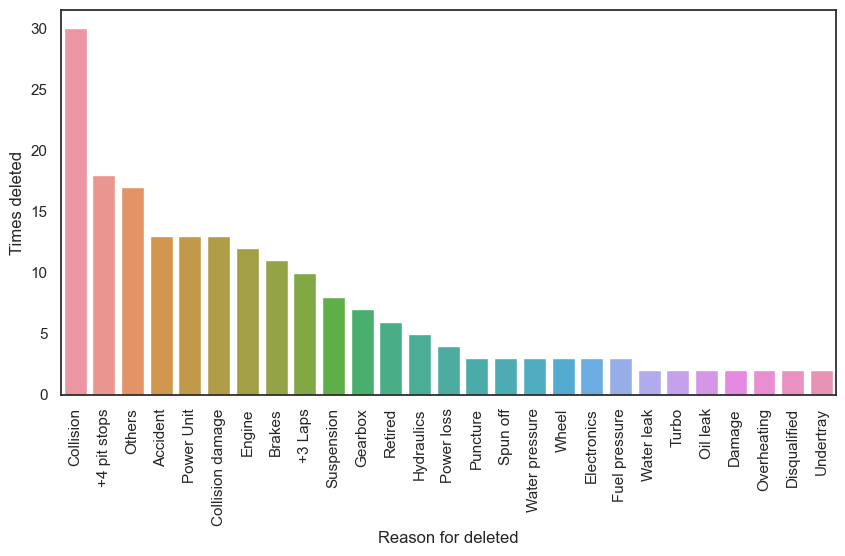

In [273]:
value_counts = list_remove["problem"].value_counts()

print(value_counts[value_counts == 1])

# Find values that occur only once
single_counts = value_counts[value_counts == 1].index
# Replace single-count values with 'others'
list_remove["problem"] = list_remove["problem"].replace(single_counts, "Others")
# Count the occurrences of each value in the modified Series
value_counts = list_remove["problem"].value_counts()

#plot
ax = sns.barplot(x=value_counts.index, y=value_counts.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Times deleted')
ax.set_xlabel('Reason for deleted')

## Null values

In [274]:
null_cols = df.columns[df.isnull().any()]
print(null_cols)

Index(['QualyPosition', 'DriverStandings'], dtype='object')


In [275]:
def remove_null (df): 
    #Qualy Position and GridPosition
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ( np.isnan(val["QualyPosition"].iloc[0])):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "QualyPosition"] = val["Position"].iloc[0]
                if ( val["GridPosition"].iloc[0] == 0):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "GridPosition"] = val["Position"].iloc[0]
    
    #DriverStandings
    df['DriverStandings'] = df['DriverStandings'].fillna(0)

    return df

In [276]:
df = remove_null (df)

### Export df

In [277]:
df.to_csv('data/combined_dataframe_clean.csv', index=False, header=True, sep ='\t' )

## Final number laps

In [278]:
print("Number rows dataframe after preprocesing: ")
print(len(df))

Number rows dataframe after preprocesing: 
63697


In [279]:
df = df.reset_index(drop=True)  # Reset the index labels

In [280]:
df

,Year,RaceNumber,RaceName,Driver,Team,GridPosition,LapNumber,Compound,TyreLife,TyresChange,...,Position,TimeLap,TimeDiffAhead,TimeDiffBehind,TimeDiffToLeader,NumberPitStops,HasPitLap,DriverAheadPit,DriverBehindPit,GoodPitStop
0,2019,1,Australian Grand Prix,BOT,Mercedes,2,1,SOFT,4.0,0,...,1,00:01:33.813000,0 days 00:00:00,0 days 00:00:01.074000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
1,2019,1,Australian Grand Prix,BOT,Mercedes,2,2,SOFT,5.0,0,...,1,00:01:29.662000,0 days 00:00:00,0 days 00:00:01.171000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
2,2019,1,Australian Grand Prix,BOT,Mercedes,2,3,SOFT,6.0,0,...,1,00:01:29.246000,0 days 00:00:00,0 days 00:00:01.257000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
3,2019,1,Australian Grand Prix,BOT,Mercedes,2,4,SOFT,7.0,0,...,1,00:01:28.641000,0 days 00:00:00,0 days 00:00:01.420000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
4,2019,1,Australian Grand Prix,BOT,Mercedes,2,5,SOFT,8.0,0,...,1,00:01:28.759000,0 days 00:00:00,0 days 00:00:01.575000,0 days 00:00:00,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63692,2022,22,Abu Dhabi Grand Prix,MAG,Haas F1 Team,16,53,MEDIUM,25.0,1,...,18,00:01:32.669000,0 days 00:00:14.026000,0 days 00:00:32.494000,0 days 00:02:07.740000,1.0,0.0,1.0,1.0,0
63693,2022,22,Abu Dhabi Grand Prix,MAG,Haas F1 Team,16,54,MEDIUM,26.0,1,...,18,00:01:33.057000,0 days 00:00:13.176000,0 days 00:00:35.848000,0 days 00:02:11.405000,1.0,0.0,1.0,1.0,0
63694,2022,22,Abu Dhabi Grand Prix,MAG,Haas F1 Team,16,55,MEDIUM,27.0,1,...,18,00:01:32.549000,0 days 00:00:13.155000,0 days 00:01:05.367000,0 days 00:02:14.239000,1.0,0.0,1.0,1.0,0
63695,2022,22,Abu Dhabi Grand Prix,MAG,Haas F1 Team,16,56,MEDIUM,28.0,1,...,17,00:01:32.782000,0 days 00:00:11.176000,0 days 00:00:00,0 days 00:02:17.177000,1.0,0.0,1.0,0.0,0


# Data Preprocessing

In [281]:
#v_categorical= ['Year', 'RaceName', 'Driver', 'Team', 'Compound', 'TrackStatus', 'DriverAhead', 'DriverBehind']

#TODO
v_categorical= ['Year', 'RaceName', 'Driver', 'Team', 'Compound', "TrackStatus"] #'TrackStatus' is categorical, but make in a different way 

v_numerical = ['RaceNumber', 'GridPosition', 'LapNumber', 'TyreLife', 
               'QualyPosition', 'DriverStandings', 'Position',
               'NumberPitStops']
v_binary = ['TyresChange','DriverAheadPit', 'DriverBehindPit' ]
v_date= ['TimeLap', 'TimeDiffAhead', 'TimeDiffBehind', 'TimeDiffToLeader'] # 'TimePit'

#TODO
#v_date= ['TimeDiffAhead', 'TimeDiffBehind', 'TimeDiffToLeader'] # 'TimePit'

### Categorical 

In [282]:
def categorical_enc (df):

    #Track status
    trackStatus_encoded =  pd.DataFrame()
    df['TrackStatus'] = df['TrackStatus'].astype(str)
    for num in range(1, 8):
        col_name = 'status_' + str(num)
        trackStatus_encoded[col_name] = df['TrackStatus'].str.contains(str(num)).astype(int)
    
    #the rest
    ohe = OneHotEncoder(sparse=False)
    categorical_encoded = pd.DataFrame(ohe.fit_transform(df[v_categorical]))
    # Get feature names from encoder and combine with unique values
    feature_names = [f"{col}_{val}" for col, vals in zip(v_categorical, v_categorical) for val in ohe.categories_[v_categorical.index(col)]]
    categorical_encoded.columns = feature_names

    #Combine with track status 
    categorical_encoded = pd.concat([categorical_encoded, trackStatus_encoded], axis=1)

    return categorical_encoded

### Binary

In [283]:
def binary_enc (df):
    #It's already encoded, juto convert all to int 
    binary_encoded = df[v_binary].astype(int)
    return binary_encoded

### Numerical

In [284]:
def numerical_enc (df):
    #StandarScaler
    scaler = StandardScaler()
    numerical_encoded = df.groupby(['Year', 'RaceNumber'])[v_numerical].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

    return numerical_encoded

### Date

In [285]:
def date_enc(df):
    #Convert the times to secods 
    #TODO
    df['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
    df['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
    df['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
    df['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()

    scaler = StandardScaler()
    date_encoded = df.groupby(['Year', 'RaceNumber'])[v_date].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

    return date_encoded

## Enconde

In [286]:
def encode_df (df): 
    categorical_encoded = categorical_enc(df)
    binary_encoded = binary_enc(df)
    numerical_encoded = numerical_enc(df)
    date_encoded = date_enc(df)

    df_encoded = pd.concat([categorical_encoded, binary_encoded, numerical_encoded, date_encoded], axis=1)
    return df_encoded

In [287]:
df_encoded = encode_df (df)
df_encoded

,Year_2019,Year_2020,Year_2021,Year_2022,RaceName_70th Anniversary Grand Prix,RaceName_Abu Dhabi Grand Prix,RaceName_Australian Grand Prix,RaceName_Austrian Grand Prix,RaceName_Azerbaijan Grand Prix,RaceName_Bahrain Grand Prix,...,LapNumber,TyreLife,QualyPosition,DriverStandings,Position,NumberPitStops,TimeLap,TimeDiffAhead,TimeDiffBehind,TimeDiffToLeader
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.701740,-1.211369,-1.377895,0.000000,-1.584317,-1.344471,1.133858,-0.680778,-0.544589,-1.288219
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.641308,-1.119913,-1.377895,0.000000,-1.584317,-1.344471,-0.119731,-0.680778,-0.539114,-1.288219
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.580875,-1.028457,-1.377895,0.000000,-1.584317,-1.344471,-0.245362,-0.680778,-0.534259,-1.288219
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.520442,-0.937001,-1.377895,0.000000,-1.584317,-1.344471,-0.428070,-0.680778,-0.525058,-1.288219
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.460009,-0.845545,-1.377895,0.000000,-1.584317,-1.344471,-0.392434,-0.680778,-0.516308,-1.288219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63692,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.422559,1.393083,1.027476,0.473854,1.469650,0.119666,0.163181,2.296950,4.485850,2.794199
63693,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.482647,1.509222,1.027476,0.473854,1.469650,0.119666,0.268443,2.100669,5.030943,2.911249
63694,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.542735,1.625362,1.027476,0.473854,1.469650,0.119666,0.130626,2.095820,9.828378,3.001758
63695,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.602824,1.741502,1.027476,0.473854,1.286434,0.119666,0.193837,1.638832,-0.795083,3.095589


# Classification

### Split dataframe
* Train -> 2019 2020
* Validation  -> 2021
* Test -> 2022

In [288]:
def conf_matrix_classifier_from_predictions(classifier, X, y, name = ""):
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X,
        y,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title('Confusion Matrix: ' + name)
    plt.show()

In [290]:
#! TODO
from sklearn.model_selection import train_test_split 
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitNextLap'], test_size=0.3, random_state=4815)
X_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['PitNextLap'], test_size=0.3, random_state=4815)

#TODO Add validation and and 2023
train_years= [2019, 2020, 2021]
test_years = [2022]

y_train_years_GP = df[df['Year'].isin(train_years)]['GoodPitNextLap']
y_test_years_GP= df[df['Year'].isin(test_years)]['GoodPitNextLap']
X_train_years_GP = df_encoded.loc[y_train_years_GP.index]
X_test_years_GP = df_encoded.loc[y_test_years_GP.index]

y_train_years_HP = df[df['Year'].isin(train_years)]['PitNextLap']
y_test_years_HP= df[df['Year'].isin(test_years)]['PitNextLap']
X_train_years_HP = df_encoded.loc[y_train_years_HP.index]
X_test_years_HP = df_encoded.loc[y_test_years_HP.index]

In [291]:
"""

#TODO Add validation and and 2023
train_years= [2019, 2020, 2021]
test_years = [2022]

y_train_years_GP = df[df['Year'].isin(train_years)]['GoodPitStop']
y_test_years_GP= df[df['Year'].isin(test_years)]['GoodPitStop']
X_train_years_GP = df_encoded.loc[y_train_years_GP.index]
X_test_years_GP = df_encoded.loc[y_test_years_GP.index]

y_train_years_HP = df[df['Year'].isin(train_years)]['HasPitLap']
y_test_years_HP= df[df['Year'].isin(test_years)]['HasPitLap']
X_train_years_HP = df_encoded.loc[y_train_years_HP.index]
X_test_years_HP = df_encoded.loc[y_test_years_HP.index]


from sklearn.model_selection import train_test_split 
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitStop'], test_size=0.3, random_state=4815)
X_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['HasPitLap'], test_size=0.3, random_state=4815)
"""

"\n\n#TODO Add validation and and 2023\ntrain_years= [2019, 2020, 2021]\ntest_years = [2022]\n\ny_train_years_GP = df[df['Year'].isin(train_years)]['GoodPitStop']\ny_test_years_GP= df[df['Year'].isin(test_years)]['GoodPitStop']\nX_train_years_GP = df_encoded.loc[y_train_years_GP.index]\nX_test_years_GP = df_encoded.loc[y_test_years_GP.index]\n\ny_train_years_HP = df[df['Year'].isin(train_years)]['HasPitLap']\ny_test_years_HP= df[df['Year'].isin(test_years)]['HasPitLap']\nX_train_years_HP = df_encoded.loc[y_train_years_HP.index]\nX_test_years_HP = df_encoded.loc[y_test_years_HP.index]\n\n\nfrom sklearn.model_selection import train_test_split \nX_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitStop'], test_size=0.3, random_state=4815)\nX_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['HasPitLap'], test_size=0.3, random_state=4815)\n"

### Random forest

In [292]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight="balanced")
print("F1 score values Random Forest:")
#Pit stop 

#Random split
rf.fit(X_train_HP, y_train_HP)
y_pred = rf.predict(X_test_HP)
print( "train_test_split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_HP,y_pred),3)))

""" 

#Year split
rf.fit(X_train_years_HP, y_train_years_HP)
y_pred = rf.predict(X_test_years_HP)
print( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))


#Good pit stop 
#Random split
rf.fit(X_train_HP, y_train_GP)
y_pred = rf.predict(X_test_GP)
print( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))
#Year split
rf.fit(X_train_years_GP, y_train_years_GP)
y_pred = rf.predict(X_test_years_GP)
print( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3)))
"""


F1 score values Random Forest:
train_test_split for HasPitLap : 0.079


' \n\n#Year split\nrf.fit(X_train_years_HP, y_train_years_HP)\ny_pred = rf.predict(X_test_years_HP)\nprint( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))\n\n\n#Good pit stop \n#Random split\nrf.fit(X_train_HP, y_train_GP)\ny_pred = rf.predict(X_test_GP)\nprint( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))\n#Year split\nrf.fit(X_train_years_GP, y_train_years_GP)\ny_pred = rf.predict(X_test_years_GP)\nprint( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3)))\n'

### SVM

In [293]:
from sklearn.svm import SVC
from sklearn import metrics

SVM_res = SVC()

SVM_res = SVC(class_weight="balanced")
print("F1 score values SMV:")
#Pit stop 

#Random split
SVM_res.fit(X_train_HP, y_train_HP)
y_pred = SVM_res.predict(X_test_HP)
print( "train_test_split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_HP,y_pred),3)))

""" 
#Year split
SVM_res.fit(X_train_years_HP, y_train_years_HP)
y_pred = SVM_res.predict(X_test_years_HP)
print( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))


#Good pit stop 
#Random split
SVM_res.fit(X_train_HP, y_train_GP)
y_pred = SVM_res.predict(X_test_GP)
print( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))
#Year split
SVM_res.fit(X_train_years_GP, y_train_years_GP)
y_pred = SVM_res.predict(X_test_years_GP)
print( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3))
"""


F1 score values SMV:
train_test_split for HasPitLap : 0.22


' \n#Year split\nSVM_res.fit(X_train_years_HP, y_train_years_HP)\ny_pred = SVM_res.predict(X_test_years_HP)\nprint( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))\n\n\n#Good pit stop \n#Random split\nSVM_res.fit(X_train_HP, y_train_GP)\ny_pred = SVM_res.predict(X_test_GP)\nprint( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))\n#Year split\nSVM_res.fit(X_train_years_GP, y_train_years_GP)\ny_pred = SVM_res.predict(X_test_years_GP)\nprint( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3))\n'

### Graph 2023

In [294]:

df_2023 = pd.read_csv("data/2023.csv", sep = '\t') 

#Clean data

df_2023 = change_add_var(df_2023)

df_2023 = remonve_var(df_2023)
df_2023 = remove_rain(df_2023)
df_2023, list_remove = remove_retired(df_2023)
df_2023 = remove_null (df_2023)



#Encode
df_encoded_2023 =  encode_df(df_2023)

Total races in the DataSet: 3
Number of races that have been eliminated due to rain: 0


In [301]:
y_train_full = df['HasPitLap']
X_train_full = df_encoded.loc[y_train_full.index]


In [302]:
#This is the best results 
from sklearn.svm import SVC
SVM_res = SVC(class_weight="balanced")

#SVM_res.fit( X_train_full, y_train_full)
SVM_res.fit(X_train_HP, y_train_HP)


SVC(class_weight='balanced')

In [303]:
#Chose the one that i want to print
receN = 1

In [304]:
df_list = []
for driver in df_2023['Driver'].unique() :

    race_driver = df_2023[(df_2023['Driver'] == driver)  & (df_2023['RaceNumber'] == receN)]
    if(len(race_driver) == 0) : #its one of the deleted drivers
        continue
    
    to_predict = df_encoded_2023.loc[race_driver.index].reindex(columns=X_train_full.columns, fill_value=0)
    
    predictions = SVM_res.predict(to_predict).astype(int)
    #real = race_driver['HasPitLap'].values
    real = race_driver['PitNextLap'].values


    laps = np.arange(1, len(real)+1)

    driver_df = pd.DataFrame({'Driver': [driver]*len(real),
                              'Real': real,
                              'Predict': predictions,
                              'Lap': laps})

    df_list.append(driver_df)

plot_df = pd.concat(df_list, ignore_index=True)

# Create a colum for the color 
# 0: No pit, not predicted 
# 1: No pit, yes predicted 
# 2: Yes pit, not predicted 
# 3: Yes pit, yes predicted 
plot_df['ColorCode'] = (plot_df['Real'] * 2 + plot_df['Predict']).astype(int)


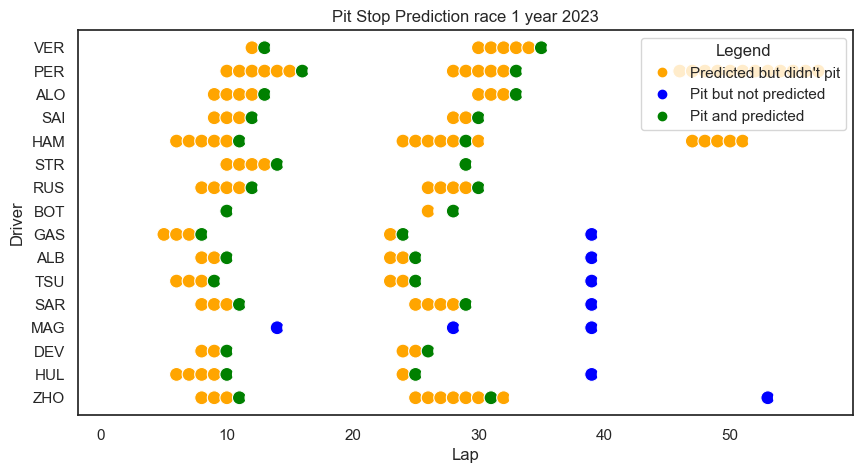

In [307]:
import seaborn as sns

# Define color palette and labels
palette = {0: 'white', 1: 'orange', 2: 'blue', 3: 'green'}
labels = { 1: 'Predicted but didn\'t pit', 2: 'Pit but not predicted', 3: 'Pit and predicted'}
label_colors = { 1: 'orange', 2: 'blue', 3: 'green'}

# Create scatter plot
sns.scatterplot(data=plot_df, x='Lap', y='Driver', hue='ColorCode', palette=palette, s=100)

# Add title and legend
plt.title('Pit Stop Prediction race 1 year 2023')
#plt.legend(title='Legend', labels=labels.values(),  loc='upper right')
plt.legend(title='Legend', labels=labels.values(),  loc='upper right', 
           handles=[plt.Line2D([], [], marker='o', color=label_colors[i], linestyle='') for i in labels.keys()])

plt.show()

### Random forest

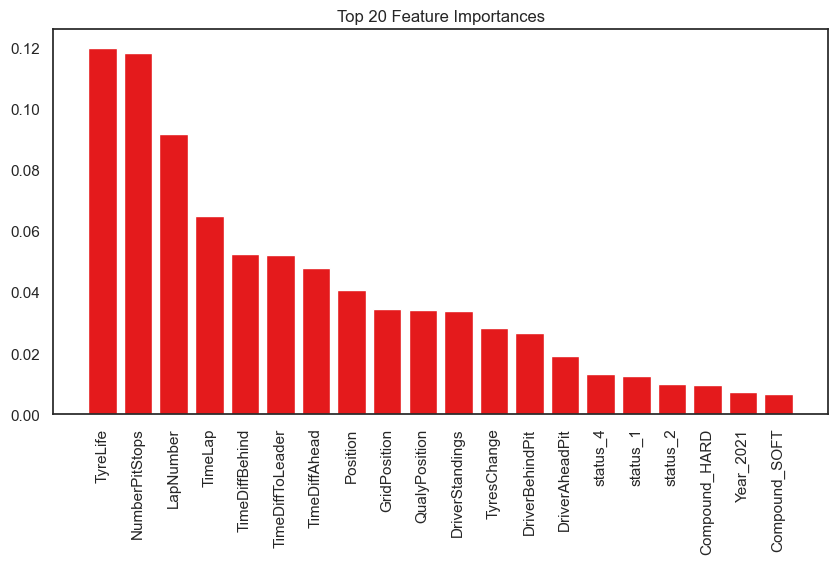

In [311]:
import matplotlib.pyplot as plt

# Train random forest classifier
rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X_train_HP, y_train_HP)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]


# Set number of features to plot
num_features = 20

# Plot feature importances for the top num_features
plt.figure()
plt.title(f"Top {num_features} Feature Importances")
plt.bar(range(num_features), importances[indices][:num_features])
plt.xticks(range(num_features), X_train_HP.columns[indices][:num_features], rotation=90)
plt.show()

### Ramdom forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


NameError: name 'X_train' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train, y_train, cv=5)

print("Cross-validation scores: {}".format(scores))
print("Mean accuracy: {:.3f}".format(scores.mean()))

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

Cross-validation scores: [0.98750867 0.98600509 0.98230396 0.98600347 0.98611914]
Mean accuracy: 0.986


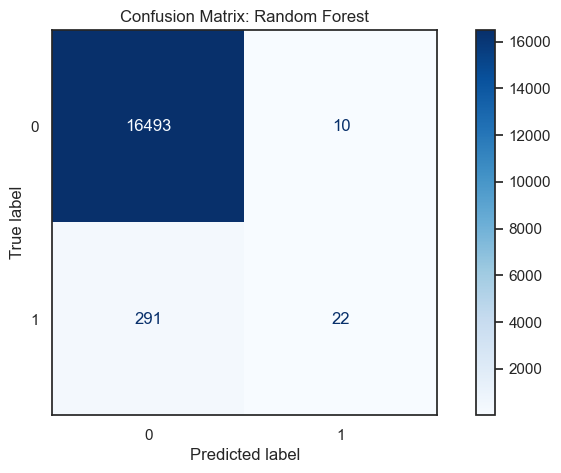

[[16493    10]
 [  291    22]]
Accuracy : 0.982
Precision : 0.688
Recall : 0.07
F1 : 0.128


In [ ]:
conf_matrix_classifier_from_predictions(rf, X_test, y_test, name = 'Random Forest')

print(metrics.confusion_matrix(y_test,y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,y_pred),3)))

### SVM

In [314]:
from sklearn.svm import SVC
from sklearn import metrics

rf.fit(X_train_HP, y_train_HP)

SVM_res = SVC(class_weight="balanced")
SVM_res.fit(X_train_HP, y_train_HP)
Y_pred = SVM_res.predict(X_test_HP)


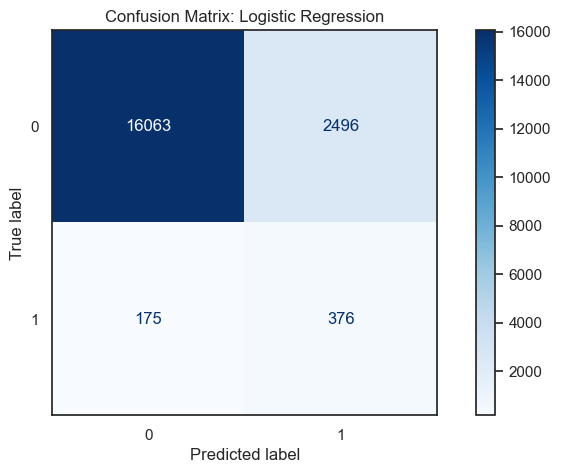

[[16063  2496]
 [  175   376]]
Accuracy : 0.86
Precision : 0.131
Recall : 0.682
F1 : 0.22


In [315]:
conf_matrix_classifier_from_predictions(SVM_res, X_test_HP, y_test_HP, name = 'Logistic Regression')


print(metrics.confusion_matrix(y_test_HP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_HP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_HP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_HP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_HP,Y_pred),3)))

In [318]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10]}

# Create an SVM object
svm = SVC(class_weight="balanced")

# Perform a grid search over the parameter grid
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_HP, y_train_HP)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best model to make predictions on the test data
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_HP)

# Print the classification report
print(classification_report(y_test_HP, y_pred))

KeyboardInterrupt: 